# Trading strategy using a combination of experts
TALBA YOUSSOUFA Mamoudou

##Abstract: 
The general framework we will follow is about predicting an unknown sequence, using a combination of experts, more or less trustworthy. 


During the process, the goal of the operator which experts are reliable, in order to use their predictions.


Here, in order to be more robust and simulate the use of various information sources (price of correlated stocks, macro event in the market etc...) our experts will be different trading strategies. The level of trust of each of them will be represented by a weight (real number). If an expert performs well (we will discuss later what 'perform well' means), his weight increases and vice-versa.

A global reference of prediction using experts advices can be found in "Cesa-Bianchi, N., & Lugosi, G. (2006). Prediction, learning, and games. Cambridge university press".

## Brief theoretical overview

We will give a brief overview of the setting necessary for our work.

The goal is to predict the values of an unknown sequence $y_{1},y_{2},y_{3}...$ of a set $S$. At hand, we have a set of experts $e_{i}, i \in [1,n]$

For each timestep $t \in \mathbb N$, each expert $e_{i}$ predicts a value $f_{i,t}$ which will be his estimate of the unknown value $y_{t}$. Using these predictions, and the past reliability of the experts(their weights), we compute our own estimation $\hat{y}_{t}$ of $y_{t}$. 

After that, the true value $y_{t}$ is then revealed and, following the success or failure of our prediction, we update their weights.

In order to measure success and failure, we will use a loss function $l: S \times S → \mathbb R_{+}$.

The goal of the operator is to have, with respect to each expert, the minimum cumulative regret. This quantity is defined by: $R_{i,T} = ∑_{t=0}^{T}l(\hat y_{t},y_{t}) - l(f_{i,t},y_{t}) = (\hat L)_{T} - L_{i,t}$


It represents the difference between the operator's cumulative loss $\hat L_{T}$ and the $i$-th expert's cumulative loss. Its name comes from the fact that if the regret is positive, the operator's total loss is greater than the expert's one, thus the operator should have followed his recommendations.

The criteria studied in this field aim to ensure that the average cumulative regret converges towards 0 for every expert ie:
$\frac{1}{T}(\hat L_{T} - L_{i,T}) → 0$,  $∀$ $i ∈ [1,n]$. $ (*)$

A simple prediction way that ensures the condition above is by averaging the experts predictions:
$\hat{y}_{t} = \frac{∑_{i=1}^{N}ω_{i,t-1}f_{i,t}}{∑_{i=1}^{N}ω_{i,t-1}}$. $(**)$ 

$w_{i,t-1}$ is the weight representing the trust in expert $e_{i}$, after the reveal of $y_{t-1}$. These weights are updated using the observed result $y_{t-1}$ and the cumulative regret at that time step.

An important idea here is to rewrite the previous equation $(**)$ using a potential $Φ$, in order to obtain the relation $(*)$ above. Indeed we have:
$\hat{y}_{t} = \frac{∑_{i=1}^{N} ∇Φ(R_{t-1})_{i} f_{i,t}}{∑_{i=1}^{N} ∇Φ(R_{t-1})_{i}} $ with $∇Φ(R_{t-1})_{i}$ being the $i-$th partial derivative of $\Phi$.


## What is used in this notebook
Since our goal here is rather to build a trading strategy than predicting a sequence, I will not use a loss function in order to define the regret but just the difference between our cumulative profit and an expert's cumulative profit.


$R_{i,t} = cumulProfit(e_{i},time_t) - cumulProfit(operator,time_t)$


In order to compute the experts weights, I will use the potential:
$𝛟_{p}(u) = \frac{1}{η} \times \log(∑_{i=1}^{n}exp(η \times u) $ resulting in the weights:
$\omega_{i,t} = ∇Φ(R_{t})_{i} = \frac{\exp(R_{i,t})}{\sum_{j=1}^{N}\exp(R_{j,t})}$

We will begin by simply using threeo experts:

*   The first one will implement a mean reversion strategy
*   The second one will use a lstm network
*   The third one will use Arima


### Mean reversion expert
When working on a day $i$, this expert will check if the price of the stock is too high or not, relatively to the 20 previous days. 

If the price is too high, we will bet on the fact that it will then decrease towards the 20 previous days mean, and go on a short position. Short positions will be represented by "-1".

If the price is too low, we will bet on the fact that it will then increase towards the 20 previous days mean, and go on a long position. Long positions will be represented by "1".

Otherwise, we just wait the next day. In this case, the position will be "0"

The sensitivity I choose here is 2 times the standard deviation of the 20 previous days (ie: "price is too high" means "price > mean + 2 standard_deviation", "price is too low" means "price < mean - 2 standard_deviation" )

### Lstm expert
On the day $i$ expert will use a long-short-term memory network to predict the stock's price on the next day. 

If the value predicted is significantly higher than the current day's price (significantly higher = +1 %), we will assume that an increase is likely to happen, and then go on a long position. Long positions will be represented by "1".

If the value predicted is significantly lower than the current day's price (significantly lower = -1 %), we will assume that a decrease is likely to happen, and then go on a short position. Short positions will be represented by "-1".

In order to avoid using training data as test data, this expert will wait until 1000 days before doing predictions, taking the 1000 first days prices as
training_data. After that, every 1000 steps, the model will be updated to fit to the 1000 last days. We will decrease the number of epochs and learning rate through time. 

Every 1000 days, we will also reset the regrets, thus the weights of the two experts. We will do this in order to undermine the effect of the beginnings on our predictions. 

### Arima expert
We will use Arima the same way we use lstm. Having predicted a price for the next day, we will decide, if the change is significant enough, to go for a long or a short position.

Arima is interesting because it allows us to build a model learning in an online fashion, unlike lstm for wish we retrain every 1000 days. Arima then seems more suitable for our use case.

### How are they combined ?

When I compute the two weights, I compute the weighted position:
$pos = \frac{w_{1} \times pos_{1}+ w_{2} \times pos_{2} + w_{3}\times pos_{3}}{w_{1} + w_{2} + w_{3} }$


*   If $pos > 0.1$, then we go on a long position (1)
*   If $pos < -0.1$, then we go on a short position (-1)
*   Otherwise, we wait until the next day (0)

### Hyperparameters choice

A large part of the hyperparameters used in this work have been chosen arbitrarily. Howerver it is straighforward to see that one could build several experts using the same strategy (e.g LSTM) but with different sets of hyperparamaters, and let the best ones win the race (the weights of the bad experts will quickly decrease with time).






#### Imports

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 88.3 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import math

#### The class embodying our trading process

In [3]:
class trading_strategy():

    def __init__(self,nlag=12) :
        self.time = 0      #represents the day
        self.nlag = nlag   #Number of days used by the lstm predictor
        self.hist = []     #Historic of the prices
        self.min = 0       #lowest price to date,used for normalization
        self.max = 0       #highest price to date, used for normalization

        #lstm attributes
        self.poslstm = [0]  # "position lstm" : position of the lstm predictor; +1 if long, -1 if short, 0 otherwise.
        self.prolstm = [0]  # "profit lstm": keeps track of the profit of the lstm predictor
        self.reglstm = [0]  # "regret lstm": for every i, reglstm[i] is the cumulative regret on day i
        self.wlstm = [0]    # "weight lstm": for every i, wlstm[i] is the lstm predictor's weight on day i

        #mean reversion attributes
        self.posmr = [0]    # "position mean reversion" : position of the mean reversion expert; +1 if long, -1 if short, 0 otherwise.
        self.promr = [0]    # "profit mean reversion": keeps track of the profit of the lstm predictor
        self.regmr = [0]    # "regret mean reversion": for every i, regmr[i] is the cumulative regret on day i
        self.wmr = [0]      # "weight mean reversion": for every i, wmrm[i] is the lstm predictor's weight on day i

        self.posar = [0]
        self.proar = [0]
        self.regar = [0]
        self.war = [0]
        
        #Our attributes
        self.posOur = [0]   # "position_our": keeps track of our position
        self.proOur = [0]   # "profit_our": keeps track of our profit

        # Initiate lstm model
        self.regressor = Sequential()  #lstm network

        #Initiate arima model
        self.arima = ARIMA(pd.Series(self.hist), order=(3,1,1))  
        

    def init_reg(self,nlag=12):
            #Builds the layers
            self.regressor.add(LSTM(units=nlag, input_shape=(nlag, 1)))
            self.regressor.add(Dense(units=1))
            opt = RMSprop(lr=0.0001)
            self.regressor.compile(optimizer = opt, loss = 'mae')


    def train_lstm(self,hist,nlag): 
       #scaling data and training the lstm predictor
       train_data = np.array(hist[len(hist)-1000:])  #training on the 1000 previous days
       train_data = (train_data - min(train_data))/(max(train_data)-min(train_data))    #scaling
       X_train = []
       y_train = []
       for i in range(self.nlag, len(train_data)):
            X_train.append(train_data[i-self.nlag:i])
            y_train.append(train_data[i])
       X_train, y_train = np.array(X_train), np.array(y_train)
       X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
       epoch = 0
       #We decrease the epoch if this is not the first learning loop, to avoid overfitting
       if self.time < 1500: 
            epoch = 200
       elif self.time < 2500:
            epoch = 100
       else:
            epoch = 50
       self.regressor.fit(X_train, y_train, validation_split=0.2, epochs = epoch, batch_size=32)


    def train_ar(self,hist):
        self.arima = ARIMA(pd.Series(self.hist), order=(3,1,1))  
        self.arima = self.arima.fit()  


    def forward(self,y): 
        #On each day i, computes the predictions, updates all the parameters of the problem
        self.hist.append(y)
        if self.time == 0:
              self.init_reg(nlag=12)
        if self.time > 1 and self.time % 1000 == 0: # Every 1000 days, we re-train the lstm 
              print("entrainement",self.time)
              self.train_lstm(self.hist,self.nlag)
              self.min = min(self.hist[len(self.hist)-1000:])
              self.max = max(self.hist[len(self.hist)-1000:])
        
        wmr,wlstm, war = 0,0,0
        if self.time == 0:
             wmr = 1
             wmr = wmr/(wmr+wlstm)
        if self.time > 0: 
            self.proOur.append(self.profit(self.hist,self.posOur[-1]))
            if self.time % 500 == 0:
              self.reglstm.append(0)
              self.regmr.append(0)
              self.regar.append(0)
        if self.time > 1000:
          self.forward_lstm(y)
          wlstm = np.exp(self.reglstm[-1]) 

          self.train_ar(self.hist)
          self.forward_ar(y)
          war = np.exp(self.regar[-1])

        
        self.forward_mr(y)
        wmr = np.exp(self.regmr[-1])  
        self.wmr.append(wmr/(wmr+wlstm+war))
        if self.time > 1000:
            self.wlstm.append(wlstm/(wmr+wlstm+war))
            self.war.append(war/(wmr+wlstm+war))


        if self.war[-1]*self.posar[-1] + self.wlstm[-1]*self.poslstm[-1] + self.wmr[-1]*self.posmr[-1] > 0.1: #Long
            self.posOur.append(1)
        elif self.war[-1]*self.posar[-1] + self.wlstm[-1]*self.poslstm[-1] + self.wmr[-1]*self.posmr[-1] < - 0.1: #Short
            self.posOur.append(-1)
        else:
            self.posOur.append(0)
        self.time = self.time + 1


    def forward_lstm(self,y):
        #prediction of the lstm expert
        if self.poslstm:
          self.prolstm.append(self.profit(self.hist,self.poslstm[-1]))
          if self.reglstm:
                  self.reglstm.append(self.reglstm[-1] + (self.prolstm[-1] - self.proOur[-1]))
        tpred = np.array(self.hist[len(self.hist)-12:])
        tpred = (tpred - self.min)/(self.max - self.min)
        tpred = np.reshape(tpred,(1, self.nlag, 1))
        predicted = self.regressor.predict(tpred)
        if (predicted*(self.max - self.min) + self.min - self.hist[-1])/self.hist[-1] > 0.001 : # predicts a more than 5% increase, go long
              self.poslstm.append(1)
        elif (predicted*(self.max - self.min) + self.min - self.hist[-1])/self.hist[-1] < -0.001: # predicts a more than 5% decrrease, go short
              self.poslstm.append(-1)
        else:
              self.poslstm.append(0)


    def forward_ar(self,y):
      #prediction of arima expert
      if self.posar:
             self.proar.append(self.profit(self.hist,self.posar[-1]))
      if self.regar:
             self.regar.append(self.regar[-1] + (self.proar[-1] - self.proOur[-1]))
      #print("PRED",list(self.arima.forecast(1,alpha=0.05))[0])
      pred = list(self.arima.forecast(1,alpha=0.05))[0]
      #print("Dernier",self.hist[-1])
      #print("Derniere Position", self.posar)
      if (pred - self.hist[-1])/self.hist[-1] > 0.001:  # predicts a more than 5% increase, go long
            self.posar.append(1)
      elif (pred - self.hist[-1])/self.hist[-1] < -0.001:
            self.posar.append(-1)
      else:
            self.posar.append(0)



    def forward_mr(self,y):
        if self.posmr:
            self.promr.append(self.profit(self.hist,self.posmr[-1]))
        if self.regmr:
            self.regmr.append(self.regmr[-1] + (self.promr[-1] - self.proOur[-1]))
        n = len(self.hist) 
        moy = np.mean(np.array(self.hist[n-20:n])) #mean
        std = np.std(np.array(self.hist[n-20:n]))
        if y > moy + 2*std: #significantly higher than the mean, will decrease towards the mean , go short
            self.posmr.append(-1) 
        elif y < moy - 2*std: #significantly lower than the mean, will increase towards the mean, go long
            self.posmr.append(1)
        else:
            self.posmr.append(0)


    def profit(self,liste,position):
          if position == 0:
              return 0
          elif position == 1:
              return liste[len(liste)-1] - liste[len(liste)-2]
          else:
              return liste[len(liste)-2] - liste[len(liste)-1]

In [4]:
data = pd.read_csv('Brent.csv')
date = [data.iloc[i][0] for i in range(len(data))]
brent = [data.iloc[i][1] for i in range(len(data))]

Text(0, 0.5, 'price')

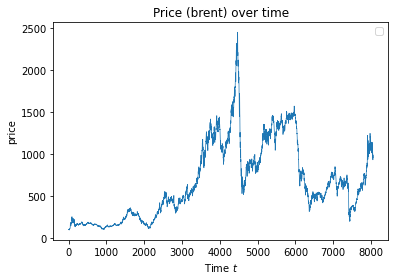

In [5]:
_test_traj_times = np.arange(len(brent))
plt.plot(_test_traj_times, brent,
         linewidth=.7)
xlims = plt.xlim()
plt.legend()
plt.title("Price (brent) over time")
plt.xlabel("Time $t$")
plt.ylabel('price')

In [7]:
brent = [data.iloc[i][1] for i in range(len(data))]
ts = trading_strategy() # Creates the trading_strztegy
for elt in brent[19:2500]:  # We receive every price sequentially, day by day
  ts.forward(elt)

<ipython-input-3-84ed36a71313>:35: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.arima = ARIMA(pd.Series(self.hist), order=(3,1,1))


entrainement 1000
Epoch 1/200
25/25 [==============================] - 2s 20ms/step - loss: 0.3822 - val_loss: 0.1287
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 0.3587 - val_loss: 0.1131
Epoch 3/200
25/25 [==============================] - 0s 5ms/step - loss: 0.3356 - val_loss: 0.0971
Epoch 4/200
25/25 [==============================] - 0s 5ms/step - loss: 0.3110 - val_loss: 0.0822
Epoch 5/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2850 - val_loss: 0.0704
Epoch 6/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2571 - val_loss: 0.0615
Epoch 7/200
25/25 [==============================] - 0s 5ms/step - loss: 0.2275 - val_loss: 0.0551
Epoch 8/200
25/25 [==============================] - 0s 5ms/step - loss: 0.1962 - val_loss: 0.0508
Epoch 9/200
25/25 [==============================] - 0s 5ms/step - loss: 0.1630 - val_loss: 0.0507
Epoch 10/200
25/25 [==============================] - 0s 5ms/step - loss: 0.1277 - val_los

## Performance

Of course,here to be more realistic, we could have add a stop_loss condition in our different substrategies, in order to exit the market in conditions similar to the ones of the 2008 crisis.

However we will still compute several key parameters helping us to assess our trading strategy.

### Cumulative profit

We plot the cumulative profit over time. The profits of the three experts and our profit.

Text(0, 0.5, 'profit')

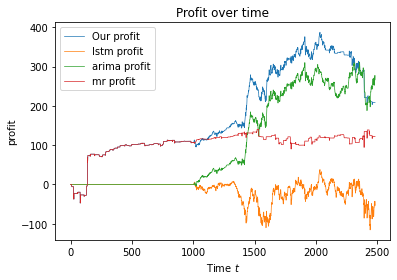

In [8]:
_test_traj_times = np.arange(len(ts.proOur)+1)
proOur= np.concatenate((np.array([0]),ts.proOur))
prolstm= np.concatenate((np.array([0]*1001),ts.prolstm))
proar= np.concatenate((np.array([0]*1001),ts.proar))
plt.plot(_test_traj_times, np.cumsum(proOur),
         linewidth=.7, label='Our profit')

plt.plot(_test_traj_times, np.cumsum(prolstm),
         linewidth=.7, label='lstm profit')
plt.plot(_test_traj_times, np.cumsum(proar),
         linewidth=.7, label='arima profit')
plt.plot(_test_traj_times, np.cumsum(ts.promr),
         linewidth=.7, label='mr profit')
xlims = plt.xlim()
plt.legend()
plt.title("Profit over time")
plt.xlabel("Time $t$")
plt.ylabel('profit')

### Step by step profit (non-cumulative)

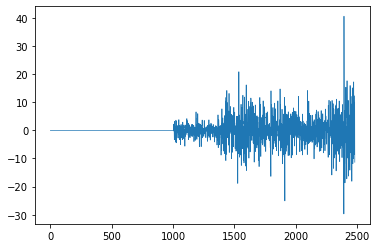

In [9]:
proOur= np.concatenate((np.array([0]),ts.proOur))
prolstm= np.concatenate((np.array([0]*1001),ts.prolstm))
proar= np.concatenate((np.array([0]*1001),ts.proar))
plt.plot(_test_traj_times, prolstm,
         linewidth=.7, label='lstm profit')
plt.legend()
plt.title("Lstm non cumulative profit over time")
plt.xlabel("Time $t$")
plt.ylabel('profit')

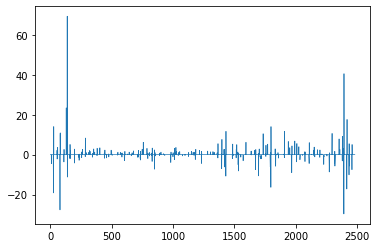

In [10]:
plt.plot(_test_traj_times, ts.promr,
         linewidth=.7, label='mr profit')
plt.legend()
plt.title("Mean regression non cumulative profit over time")
plt.xlabel("Time $t$")
plt.ylabel('profit')

Text(0, 0.5, 'profit')

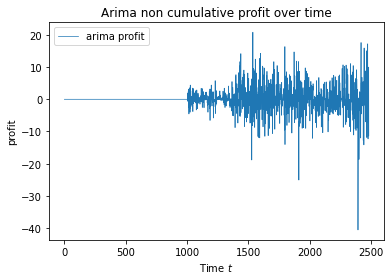

In [11]:
plt.plot(_test_traj_times, proar,
         linewidth=.7, label='arima profit')
plt.legend()
plt.title("Arima non cumulative profit over time")
plt.xlabel("Time $t$")
plt.ylabel('profit')

Text(0, 0.5, 'profit')

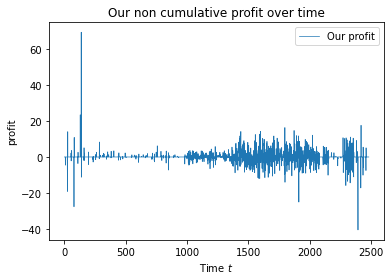

In [12]:
plt.plot(_test_traj_times, proOur,
         linewidth=.7, label='Our profit')
plt.legend()
plt.title("Our non cumulative profit over time")
plt.xlabel("Time $t$")
plt.ylabel('profit')

### Regret

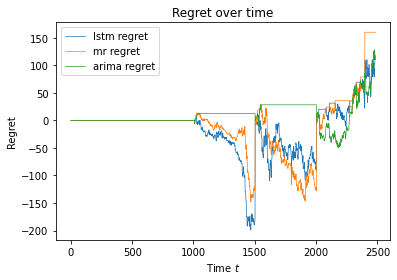

In [24]:
_test_traj_times = np.arange(len(ts.proOur)+1)
reglstm= np.concatenate((np.array([0]*1001),ts.reglstm))
regar= np.concatenate((np.array([0]*1001),ts.regar))
regmr = np.array(ts.regmr[:len(ts.regmr)])
plt.plot(_test_traj_times, reglstm[:len(regmr)-4],
         linewidth=.7, label='lstm regret')
#print(len(_test_traj_times),len(regmr))
plt.plot(_test_traj_times, regmr[:len(regmr)-4],
         linewidth=.7, label='mr regret')
plt.plot(_test_traj_times, regar[:len(regmr)-4],
         linewidth=.7, label='arima regret')
plt.legend()
plt.title("Regret over time")
plt.xlabel("Time $t$")
plt.ylabel('Regret')
_test_traj_times = np.arange(len(ts.proOur)+1)

### Maximal profits and losses (absolute and percentage)

In [25]:
def percentage(arr):
  #print(arr)
  #print(type(arr))
  #temp_prev = np.array(arr.append(0))
  #temp_next = np.concatenate((np.array([0]),np.array(arr)))
  diff = np.diff(np.array(arr))
  for i in range(len(diff)):
    if arr[i] != 0:
      diff[i] = (diff[i] / arr[i])
  return diff


In [26]:
perar = percentage(ts.proar)
permr = percentage(ts.promr)
perlstm = percentage(ts.prolstm)
perOur = percentage(ts.proOur)

In [27]:
#Maximal win and losses
def min_max(arr):
  max = np.max(np.diff(arr))
  min = np.min(np.diff(arr))
  return min, max
print("=== Mean regression ===")
print("Maximal win and maximal loss", min_max(ts.promr))
print("Percentage:",np.max(percentage(ts.promr)),np.min(percentage(ts.promr)))
print("=== Lstm ===")
print("Maximal win and maximal loss lstm", min_max(ts.prolstm)) 
print("Percentage:",np.max(percentage(ts.prolstm)),np.min(percentage(ts.prolstm)))
print("=== Arima ===")
print("Maximal win and maximal loss arima", min_max(ts.proar)) 
print("Percentage:",np.max(percentage(ts.proar)),np.min(percentage(ts.proar)))
print("=== Our profit ===")
print("Our Maximal win and maximal loss", min_max(ts.proOur)) 
print("Percentage:",np.max(percentage(ts.proOur)),np.min(percentage(ts.proOur)))

=== Mean regression ===
Maximal win and maximal loss (-80.61421511743032, 70.28562275064888)
Percentage: 69.38660855511412 -34.5109216835337
=== Lstm ===
Maximal win and maximal loss lstm (-34.16116859947738, 70.28562275064888)
Percentage: 83.99999999999838 -85.00000000002005
=== Arima ===
Maximal win and maximal loss arima (-40.574568068344774, 34.16116859947738)
Percentage: 83.99999999999838 -48.66666666667352
=== Our profit ===
Our Maximal win and maximal loss (-80.61421511743032, 69.38660855511412)
Percentage: 83.99999999999838 -85.00000000002005


### Sharpe ratio

We compute the Sharpe ratio using the 

In [41]:
def sharpe_ratio(arr):
  #returns array : sharpe
  #sharpe[i] is the sharpe ratio of the trading strategy for the 1000*(i+1) previous days
  arr = np.cumsum(arr)
  sigma = []
  sharpe = []
  for i in range(int(len(arr)/1000)):
    sigma.append(np.std(np.array(arr[1000*i:(i+1)*1000])))
    if sigma[-1] != 0:
      sharpe.append(arr[1000*(i+1)]/(1000*sigma[-1]))
  return sharpe
print("=== Sharpe ratio Mean regression ===")
print(sharpe_ratio(ts.promr))
print("=== Sharpe ratio Lstm ===")
print(sharpe_ratio(ts.prolstm))
print("=== Sharpe ratio Arima ===")
print(sharpe_ratio(ts.proar))
print("=== Our Sharpe ratio ===")
print(sharpe_ratio(ts.proOur))


    

=== Sharpe ratio Mean reagression ===
[0.002540242456466806, 0.012342216466421661]
=== Sharpe ratio Lstm ===
[-4.3587916035711784e-05]
=== Sharpe ratio Arima ===
[0.002902566700296954]
=== Our Sharpe ratio ===
[0.002544528007015488, 0.0040907532129049575]
